# Compare tau decay distributions between Tauola and GENIE+Geant4 simulations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from utils import load_hepmc, branching_ratios 
from collections import Counter
import numba

## Load decays

In [110]:
genie_nutau_energy = 5 # GeV

# decay_products = load_hepmc(f"../data/tauola_output_genie_e{genie_nutau_energy}.dat").groupby("event_num").nth[3:].sort_values("event_num")
decay_products_nopol = load_hepmc(f"../data/tauola_output_genie_nopol_e{genie_nutau_energy}.dat")#.groupby("event_num").nth[3:].sort_values("event_num")
decay_products_g4 = pd.read_csv(f"../data/geant4_output_e{genie_nutau_energy}.csv").sort_values("event_num")

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


In [111]:
decay_products_g4 = pd.read_csv(f"../data/geant4_output_e{genie_nutau_energy}.csv").sort_values("event_num")

In [3]:
decay_products

,event_num,pdg,E,px,py,pz
3,7,16,2.596879,0.222781,-0.683829,2.495281
4,7,-211,6.497516,-0.998736,0.610382,6.389694
8,9,16,5.663574,0.098235,-0.664739,5.623561
9,9,-211,0.355156,-0.046837,-0.120631,0.299852
10,9,111,3.584363,0.070328,0.697047,3.512637
...,...,...,...,...,...,...
2630802,999995,16,5.224114,-0.392318,-0.767595,5.152489
2630809,999996,-211,1.825069,-0.147094,-0.001521,1.813770
2630810,999996,-211,0.143598,0.025659,-0.003986,0.021608
2630808,999996,16,1.525003,-0.278366,0.643834,1.354076


In [104]:
decay_products_nopol

,event_num,pdg,E,px,py,pz
0,4,1000080160,14.895100,0.000000,0.000000,0.000000
1,4,16,5.000000,0.000000,0.000000,5.000000
2,4,15,3.674610,-0.000156,-0.074013,3.215590
3,4,16,2.926796,0.559238,-0.377204,2.847983
4,4,-211,0.748086,-0.559394,0.303186,0.367845
...,...,...,...,...,...,...
962326,995224,16,5.000000,0.000000,0.000000,5.000000
962327,995224,15,4.466730,0.114606,0.482910,4.067930
962328,995224,16,1.072256,0.631138,0.398764,0.769601
962329,995224,11,3.073834,-0.520938,-0.088451,3.028078


In [112]:
decay_products_g4

,event_num,pdg,E,px,py,pz
0,0,-211,2.149550,0.471007,-0.772448,1.944890
21,0,16,1.524980,-0.470983,0.699429,1.270650
41,1,-211,0.468578,0.369889,0.010412,0.251316
40,1,16,3.118620,-0.279838,-0.232610,3.097310
22,1,111,0.548567,0.403863,-0.018455,0.345342
...,...,...,...,...,...,...
476072,154396,111,1.573080,-0.210799,0.439569,1.489530
476075,154396,-211,0.374216,0.226221,-0.186625,0.185885
476076,154396,16,2.108650,-0.597034,0.439295,1.974070
476081,154397,-211,1.250420,-0.686881,0.402554,0.954049


In [6]:
assert decay_products["event_num"].nunique() == decay_products_nopol["event_num"].nunique() 
assert decay_products["event_num"].nunique() == decay_products_g4["event_num"].nunique()

## Geant4 data sanity check

From the [source code for tau decays](https://github.com/Geant4/geant4/blob/master/source/particles/leptons/src/G4TauMinus.cc) in Geant4, the branching ratios should be:
<!--Table with tau 2 columns: decay products and branching ratio -->
| Decay products | Branching ratio |
|----------------|-----------------|
| $mu \nu_tau \bar\nu_mu | 0.1736  |
| $e \nu_tau \bar\nu_e | 0.1784    |
| $\pi^- \nu_tau | 0.1106 |

```c++
 mode = new G4TauLeptonicDecayChannel("tau-", 0.1736, "mu-");
    table->Insert(mode);
    // tau- -> e- + anti_nu_e + nu_tau
    mode = new G4TauLeptonicDecayChannel("tau-", 0.1784, "e-");
    table->Insert(mode);
    // tau- -> pi- + nu_tau
    mode = new G4PhaseSpaceDecayChannel("tau-", 0.1106, 2, "pi-", "nu_tau");
    table->Insert(mode);
    // tau- -> pi0 + pi- + nu_tau
    mode = new G4PhaseSpaceDecayChannel("tau-", 0.2541, 3, "pi0", "pi-", "nu_tau");
    table->Insert(mode);
    // tau- -> pi0 + pi0 + pi- + nu_tau
    mode = new G4PhaseSpaceDecayChannel();
    mode->SetParent("tau-");
    mode->SetBR(0.0917);
    mode->SetNumberOfDaughters(4);
    mode->SetDaughter(0, "pi0");
    mode->SetDaughter(1, "pi0");
    mode->SetDaughter(2, "pi-");
    mode->SetDaughter(3, "nu_tau");
    table->Insert(mode);
    // tau- -> pi- + pi- + pi+ + nu_tau
    mode = new G4PhaseSpaceDecayChannel();
    mode->SetParent("tau-");
    mode->SetBR(0.0946);
    mode->SetNumberOfDaughters(4);
    mode->SetDaughter(0, "pi-");
    mode->SetDaughter(1, "pi-");
    mode->SetDaughter(2, "pi+");
    mode->SetDaughter(3, "nu_tau");
    table->Insert(mode);

    anInstance->SetDecayTable(table);
```

In [113]:
taus = pd.read_csv(f"../data/genie_pol_e{genie_nutau_energy}.csv").sort_values("event_num")
taus

,event_num,pdg,E,px,py,pz,polx,poly,polz
0,4,15,3.67461,-0.000156,-0.074012,3.21559,0.000048,0.023011,-0.999735
1,5,15,4.13579,0.493657,-0.240467,3.69405,0.000000,0.000000,0.000000
2,15,15,3.31492,-0.107529,-0.036129,2.79617,0.038424,0.012910,-0.999178
3,20,15,4.69982,-0.441461,0.209511,4.32346,0.000000,0.000000,0.000000
4,22,15,3.52693,0.523667,0.128337,2.99855,-0.171884,-0.042124,-0.984216
...,...,...,...,...,...,...,...,...,...
154393,995189,15,3.79233,-0.418670,-0.278067,3.31239,0.000000,0.000000,0.000000
154394,995201,15,4.37156,-0.744747,-0.107314,3.92264,0.000000,0.000000,0.000000
154395,995214,15,3.59273,-0.117279,-0.596226,3.06287,0.037559,0.190941,-0.980883
154396,995223,15,4.52561,-0.583319,0.568008,4.08179,0.000000,0.000000,0.000000


In [114]:
# Take the event_num in decay_products_g4, use it as the index for event_num in taus, and then create a new array with those values as the event_num in decay_products_g4
decay_products_g4["event_num"] = taus["event_num"][decay_products_g4["event_num"]].values
decay_products_g4

,event_num,pdg,E,px,py,pz
0,4,-211,2.149550,0.471007,-0.772448,1.944890
21,4,16,1.524980,-0.470983,0.699429,1.270650
41,5,-211,0.468578,0.369889,0.010412,0.251316
40,5,16,3.118620,-0.279838,-0.232610,3.097310
22,5,111,0.548567,0.403863,-0.018455,0.345342
...,...,...,...,...,...,...
476072,995223,111,1.573080,-0.210799,0.439569,1.489530
476075,995223,-211,0.374216,0.226221,-0.186625,0.185885
476076,995223,16,2.108650,-0.597034,0.439295,1.974070
476081,995224,-211,1.250420,-0.686881,0.402554,0.954049


In [115]:
# Group by event_num and calculate the sum of the 4-momentum
tau_rec = decay_products_g4.groupby("event_num")[["E", "px", "py", "pz"]].sum()
closeness = np.isclose(tau_rec, taus.loc[:, "E":"pz"], atol=0.01)

In [117]:
bad_event_nums = taus[~closeness[:, 0]]["event_num"].values

In [118]:
decay_products_g4[decay_products_g4["event_num"].isin(bad_event_nums)].head(20)

,event_num,pdg,E,px,py,pz


In [119]:
taus[taus["event_num"].isin(bad_event_nums)]

,event_num,pdg,E,px,py,pz,polx,poly,polz


In [120]:
tau_rec[tau_rec.index.isin(bad_event_nums)]

,E,px,py,pz
event_num,,,,


In [6]:
(taus.loc[:, "E"].values > tau_rec.loc[:, "E"].values).all()

True

4-momentum is not conserved at all, for some events. It seems like something is missing or that I am not saving certain particles when the tau lepton decays in Geant4.

## Plot neutrino energy distribution for Geant4 decay products

In [123]:
branching_ratios(decay_products_g4)

{(-211, 16, 111): 0.2821085765359655,
 (-12, 11, 16): 0.19684192800424877,
 (-14, 13, 16): 0.19288462285780905,
 (-211, 16): 0.12202230598841954,
 (-211, -211, 16, 211): 0.10570732781512714,
 (-211, 16, 111, 111): 0.10043523879843003}

In [124]:
def particle_energy_fraction(df, pdg, n=0):
    particle_energy = (
        df
        # .groupby("event_num")
        # .nth[3:]
        .query(f"pdg == {pdg}")
        .groupby("event_num")
        .nth(n)
        ["E"]
        .values
    )
    
    total_energy = df.groupby("event_num")["E"].sum().values
    return particle_energy / total_energy

@numba.njit
def is_pi0_pim_nutau_event(values, index) -> bool:
    """Check if a given event contains a pi0, a pi- and a tau neutrino"""
    return ((values == -211).sum() == 1) and ((values == 111).sum() == 1) and (values == 16).any() and (values.size == 3)

@numba.njit
def is_2pim_pip_nutau_event(values, index) -> bool:
    return ((values == -211).sum() == 2) and ((values == 211).sum() == 1) and (values == 16).any() and (values.size == 4)

@numba.njit
def is_2pi0_pim_nutau_event(values, index) -> bool:
    return ((values == -211).sum() == 1) and ((values == 111).sum() == 2) and (values == 16).any() and (values.size == 4)

In [125]:
from utils import filter_events

In [126]:
datasets = {"Tauola unpolarized": decay_products_nopol.groupby("event_num").nth[3:], "Geant4": decay_products_g4}

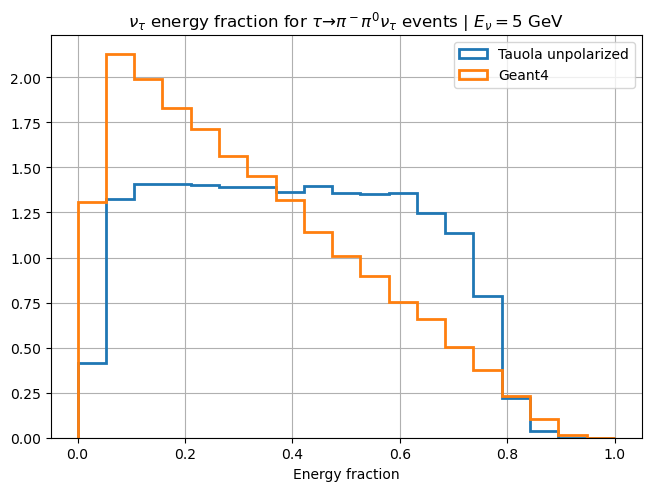

In [127]:
fig, ax = plt.subplots(
    # ncols=len(d1), 
    # nrows=2, 
    # figsize=(4, 4), 
    layout="constrained")

for label, df in datasets.items():
    selected_events = filter_events(df, "pdg", is_pi0_pim_nutau_event, engine="numba")
    ax.hist(particle_energy_fraction(selected_events, 16), bins=np.linspace(0, 1, 20), histtype="step", label=label, density=True, lw=2)

ax.set(xlabel="Energy fraction", title=r"$\nu_\tau$ energy fraction for $\tau \to \pi^- \pi^0 \nu_\tau$ events | $E_\nu =$" + f"{genie_nutau_energy} GeV")
ax.legend()
ax.grid(True)

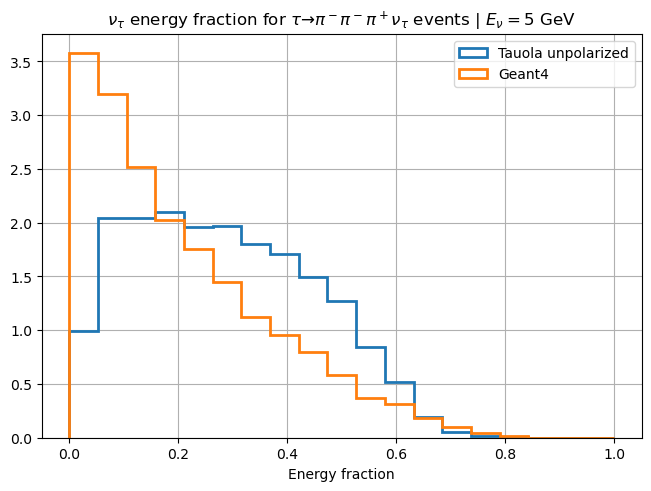

In [128]:
fig, ax = plt.subplots(
    # ncols=len(d1), 
    # nrows=2, 
    # figsize=(4, 4), 
    layout="constrained")

for label, df in datasets.items():
    selected_events = filter_events(df, "pdg", is_2pim_pip_nutau_event, engine="numba")
    ax.hist(particle_energy_fraction(selected_events, 16), bins=np.linspace(0, 1, 20), histtype="step", label=label, density=True, lw=2)

ax.set(xlabel="Energy fraction", title=r"$\nu_\tau$ energy fraction for $\tau \to \pi^- \pi^- \pi^+ \nu_\tau$ events | $E_\nu =$" + f"{genie_nutau_energy} GeV")
ax.legend()
ax.grid(True)

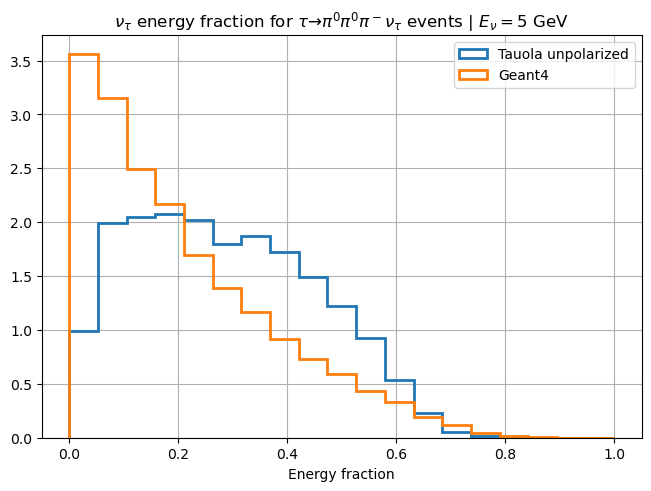

In [129]:
fig, ax = plt.subplots(
    # ncols=len(d1), 
    # nrows=2, 
    # figsize=(4, 4), 
    layout="constrained")

for label, df in datasets.items():
    selected_events = filter_events(df, "pdg", is_2pi0_pim_nutau_event, engine="numba")
    ax.hist(particle_energy_fraction(selected_events, 16), bins=np.linspace(0, 1, 20), histtype="step", label=label, density=True, lw=2)

ax.set(xlabel="Energy fraction", title=r"$\nu_\tau$ energy fraction for $\tau \to \pi^0 \pi^0 \pi^- \nu_\tau$ events | $E_\nu =$" + f"{genie_nutau_energy} GeV")
ax.legend()
ax.grid(True)

## Compare Geant4 decay products with Tauola decay products

In [28]:
def get_particle_property(decay_products: pd.DataFrame, pdg: int, prop: str) -> tuple[pd.Series, pd.Series]:
    nutau_e = decay_products.query("pdg == 16")[prop]
    anti_nutau_e = decay_products.query("pdg == -16")[prop]
    return nutau_e, anti_nutau_e


def compare_histos(nutau, anti_nutau, nutau_nopol, anti_nutau_nopol, nutau_g4, anti_nutau_g4, bins, density=None, **kwargs):
    fig, axs = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, layout="constrained")

    for ax, label, lists, in zip(axs, ("Neutrino", "Anti-neutrino"), ((nutau, nutau_nopol, nutau_g4), (anti_nutau, anti_nutau_nopol, anti_nutau_g4))):
        for energies, particle_type in zip(lists, ("polarized", "unpolarized (Tauola)", "unpolarized (Geant4)")):
            ax.hist(energies, bins=bins, label=f"{label} {particle_type}", density=density, histtype="step", lw=2)
            # ax.set_title(f"{label} {particle_type}")
            
    for ax in axs.flat:
        ax.set(**kwargs, ylabel="Density of number of neutrinos")
        ax.grid(True, alpha=0.5)
        ax.legend(fontsize="large")

    return fig, axs

In [1]:
nutau, anti_nutau = get_particle_property(decay_products, 16, "E")
nutau_nopol, anti_nutau_nopol = get_particle_property(decay_products_nopol, 16, "E")
nutau_g4, anti_nutau_g4 = get_particle_property(decay_products_g4, 16, "E")

compare_histos(nutau, anti_nutau, nutau_nopol, anti_nutau_nopol, nutau_g4, anti_nutau_g4, 
               bins=np.linspace(0, genie_nutau_energy, 50), xlabel="Neutrino energy [GeV]", density=True)

NameError: name 'get_particle_property' is not defined

/home/simon/miniconda3/envs/cern-skhep/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/simon/miniconda3/envs/cern-skhep/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: xlabel='Tau visible energy [GeV]', ylabel='Density of number of neutrinos'>,
        <Axes: xlabel='Tau visible energy [GeV]', ylabel='Density of number of neutrinos'>],
       dtype=object))

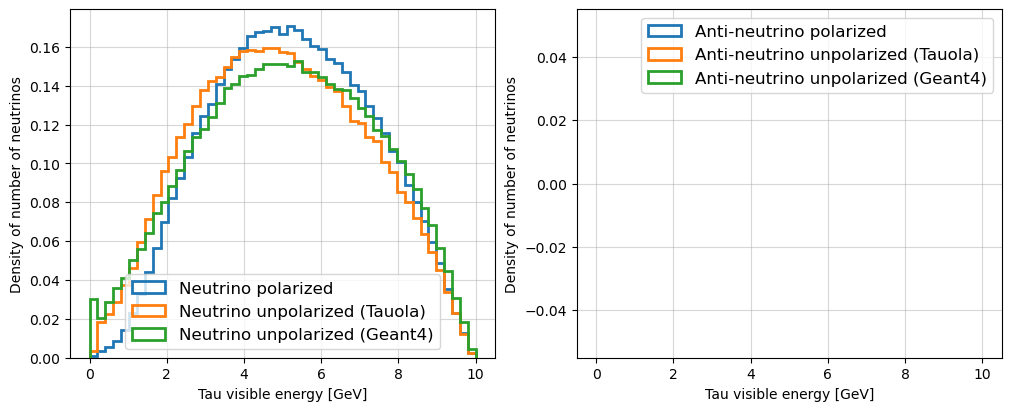

In [9]:
nutau = decay_products.query("pdg != 16").groupby("event_num")["E"].sum()
nutau_nopol = decay_products_nopol.query("pdg != 16").groupby("event_num")["E"].sum()
nutau_g4 = decay_products_g4.query("pdg != 16").groupby("event_num")["E"].sum()

compare_histos(nutau, np.array([]), nutau_nopol, np.array([]), nutau_g4, np.array([]), 
               bins=np.linspace(0, genie_nutau_energy, 50), xlabel="Tau visible energy [GeV]", density=True)

When viewing the distribution of all events (regardless of decay mode) and the neutrino energy in these cases, there is a slight shift. In the polarized simulations, the neutrinos typically have a lower energy that in the unpolarized case. This would mean that IceCube simulations using the unpolarized simulations underestimate the energy deposited in the detector, i.e., overestimate the missing energy.

## Pion momentum fraction
See Fig. 2 in the DUNE paper

In [10]:
def filter_events(decay_products: pd.DataFrame, col: str, filter_func: callable, **kwargs) -> pd.DataFrame:
    mask = decay_products.groupby("event_num")[col].agg(filter_func, **kwargs)
    allowed_events = mask[mask > 0].index
    return decay_products[decay_products["event_num"].isin(allowed_events)]

In [11]:
@numba.njit
def is_pion_nutau_event(values: np.ndarray, index: np.ndarray) -> bool:
    # at index 0, we should have the pdg, since the event number is now the index
    # print(values)
    # return True
    return (values == -211).any() and (values == 16).any() and (values.size == 2)


# Only select events that decay to a pion and a neutrino (211 and 16)
pion_neutrino_events = filter_events(decay_products, "pdg", is_pion_nutau_event, engine="numba")
pion_neutrino_events_nopol = filter_events(decay_products_nopol, "pdg", is_pion_nutau_event, engine="numba")
pion_neutrino_events_g4 = filter_events(decay_products_g4, "pdg", is_pion_nutau_event, engine="numba")

In [12]:
def pion_momentum_fraction(decay_products):
    # Calculate the momentum fraction of the tau neutrino relative to the total momentum of all decay products
    pion_momentum = (
        decay_products
        .query("pdg.abs() == 211")
        .loc[:, "px":"pz"]
        .pow(2)
        .sum(axis=1)
        .pow(0.5)
    )

    decay_products = decay_products.copy()
    decay_products.loc[:, "P"] = decay_products.loc[:, "px":"pz"].pow(2).sum(axis=1).pow(0.5)
    
    tau_momentum = (
        decay_products
        .groupby("event_num")
        ["P"].sum()
    )
    return pion_momentum.values / tau_momentum.values


def nu_momentum_fraction(decay_products):
    # Calculate the momentum fraction of the tau neutrino relative to the total momentum of all decay products
    nu_momentum = (
        decay_products
        .query("pdg.abs() == 16")
        .loc[:, "px":"pz"]
        .pow(2)
        .sum(axis=1)
        .pow(0.5)
    )

    decay_products = decay_products.copy()
    decay_products.loc[:, "P"] = decay_products.loc[:, "px":"pz"].pow(2).sum(axis=1).pow(0.5)
    
    tau_momentum = (
        decay_products
        .groupby("event_num")
        ["P"].sum()
    )
    return nu_momentum.values / tau_momentum.values

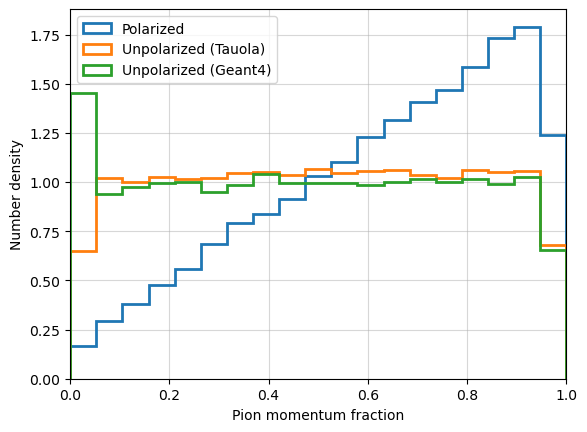

In [13]:
# Plot the momentum fraction as a histogram from 0 to 1
fig, ax = plt.subplots()
ax.hist(pion_momentum_fraction(pion_neutrino_events), bins=np.linspace(0, 1, 20), label="Polarized", histtype="step", density=True, lw=2)
ax.hist(pion_momentum_fraction(pion_neutrino_events_nopol), bins=np.linspace(0, 1, 20), label="Unpolarized (Tauola)", histtype="step", density=True, lw=2)
ax.hist(pion_momentum_fraction(pion_neutrino_events_g4), bins=np.linspace(0, 1, 20), label="Unpolarized (Geant4)", histtype="step", density=True, lw=2)
ax.set(xlim=(0, 1), xlabel="Pion momentum fraction", ylabel="Number density")
ax.grid(True, alpha=0.5)
ax.legend()

We see a clear difference between the decay using Tauola with real polarization given by GENIE and the unpolarized decay by Geant4.
A similar difference would likely be seen for the IceCube simulations.

In [14]:
@numba.njit
def is_pion_nutau_event(values: np.ndarray, index: np.ndarray) -> bool:
    # at index 0, we should have the pdg, since the event number is now the index
    # print(values)
    # return True
    return (values == -211).any() and (values == 16).any() and (values.size == 2)


# Only select events that decay to a pion and a neutrino (211 and 16)
pion_neutrino_events = filter_events(decay_products, "pdg", is_pion_nutau_event, engine="numba")
pion_neutrino_events_nopol = filter_events(decay_products_nopol, "pdg", is_pion_nutau_event, engine="numba")
pion_neutrino_events_g4 = filter_events(decay_products_g4, "pdg", is_pion_nutau_event, engine="numba")

In [15]:
@numba.njit
def is_pi0_pim_nutau_event(values, index) -> bool:
    return (values == -211).any() and (values == 111).any() and (values == 16).any() and (values.size == 3)

# Only select events that decay to a pi-, a neutrino and a pi0(211, 16 and 111)
pion_neutrino_events = filter_events(decay_products, "pdg", is_pi0_pim_nutau_event, engine="numba")
pion_neutrino_events_nopol = filter_events(decay_products_nopol, "pdg", is_pi0_pim_nutau_event, engine="numba")
pion_neutrino_events_g4 = filter_events(decay_products_g4, "pdg", is_pi0_pim_nutau_event, engine="numba")

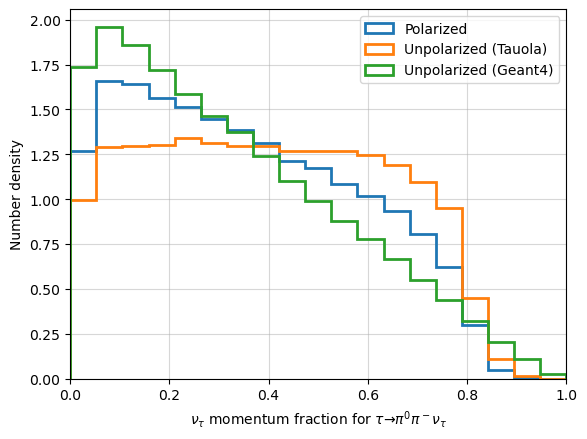

In [16]:
# Plot the momentum fraction as a histogram from 0 to 1
fig, ax = plt.subplots()
ax.hist(nu_momentum_fraction(pion_neutrino_events), bins=np.linspace(0, 1, 20), label="Polarized", histtype="step", density=True, lw=2)
ax.hist(nu_momentum_fraction(pion_neutrino_events_nopol), bins=np.linspace(0, 1, 20), label="Unpolarized (Tauola)", histtype="step", density=True, lw=2)
ax.hist(nu_momentum_fraction(pion_neutrino_events_g4), bins=np.linspace(0, 1, 20), label="Unpolarized (Geant4)", histtype="step", density=True, lw=2)
ax.set(xlim=(0, 1), xlabel=r"$\nu_\tau$ momentum fraction for $\tau\to\pi^0\pi^-\nu_\tau$", ylabel="Number density")
ax.grid(True, alpha=0.5)
ax.legend()

In [57]:
# TODO plot angular distributions of particles in tau rest frame

## Branching ratios

In [18]:
branching_ratios(decay_products)

{(-211, 16, 111): 0.2528492694970595,
 (-14, 13, 16): 0.17060075159108895,
 (-12, 11, 16): 0.15218534823878418,
 (-211, 16): 0.11143309370246281,
 (-211, 16, 111, 111): 0.09160786469464835,
 (-211, -211, 16, 211): 0.08970993133319749,
 (-211, -211, 16, 111, 211): 0.04555040067482075,
 (-12, 11, 16, 22): 0.02840502513991631,
 (-211, 16, 111, 111, 111): 0.009864040678801434,
 (-321, 16): 0.0068974831650230545,
 (-14, 13, 16, 22): 0.0058928342945421975,
 (-321, -211, 16, 211): 0.005091958544017363,
 (-321, 16, 111): 0.004672565029689269,
 (-211, 16, 310): 0.004407186082769798,
 (-211, 16, 130): 0.004328994071623882,
 (-211, 16, 111, 310): 0.0028196513110193867,
 (-211, 16, 111, 130): 0.0027225036608077946,
 (-211, 16, 111, 221): 0.001670465692662746,
 (-321, -211, 16, 321): 0.0014595842080570944,
 (-211, 16, 22, 111): 0.0012984612759988437,
 (-211, -211, 16, 111, 111, 211): 0.0008932844909700074,
 (-321, 16, 111, 310): 0.0007961368407584152,
 (-321, 16, 111, 130): 0.0007487477430942238,
 

In [19]:
branching_ratios(decay_products_nopol)

{(-211, 16, 111): 0.2526028461892057,
 (-14, 13, 16): 0.17087086944777485,
 (-12, 11, 16): 0.1524080769978059,
 (-211, 16): 0.11133831550713442,
 (-211, 16, 111, 111): 0.09188509091598387,
 (-211, -211, 16, 211): 0.08870291300783342,
 (-211, -211, 16, 111, 211): 0.04560726759201778,
 (-12, 11, 16, 22): 0.02863012335382122,
 (-211, 16, 111, 111, 111): 0.010205242181983612,
 (-321, 16): 0.007053867187314886,
 (-14, 13, 16, 22): 0.00576725318573209,
 (-321, -211, 16, 211): 0.00516778110028007,
 (-321, 16, 111): 0.004809993412915424,
 (-211, 16, 310): 0.004369274804638445,
 (-211, 16, 130): 0.004146546045616746,
 (-211, 16, 111, 130): 0.0027438287547566806,
 (-211, 16, 111, 310): 0.002731981480340633,
 (-211, 16, 111, 221): 0.0017225937000933565,
 (-321, -211, 16, 321): 0.0016159682303489259,
 (-211, 16, 22, 111): 0.0012889834564660055,
 (-211, -211, 16, 111, 111, 211): 0.0008980234007364265,
 (-321, 16, 111, 310): 0.000791397930991996,
 (-321, 16, 111, 130): 0.0007060975551964515,
 (-211,

In [14]:
branching_ratios(decay_products_g4)

{(-211, 16, 111): 0.2785104658822191,
 (-12, 11, 16): 0.19635435671669377,
 (-14, 13, 16): 0.19045204460261872,
 (-211, 16): 0.12160279406119828,
 (-211, -211, 16, 211): 0.10418256175984153,
 (-211, 16, 111, 111): 0.10039143394670622,
 (-211, 11, 16, 111): 0.00236234651855994,
 (-12, 11, 11, 16): 0.0016823129670787938,
 (-14, 11, 13, 16): 0.0016183376852321354,
 (-211, 11, 16): 0.0010046488704808572,
 (-211, -211, 11, 16, 211): 0.0009383041337509893,
 (-211, 11, 16, 111, 111): 0.0008174619347073013,
 (-211, 11, 11, 16, 111): 2.6064003715305258e-05,
 (-12, 11, 11, 11, 16): 1.895563906567655e-05,
 (-211, 11, 11, 16, 111, 111): 1.4216729299257413e-05,
 (-14, 11, 11, 13, 16): 9.477819532838276e-06,
 (-211, -211, 11, 11, 16, 211): 7.108364649628706e-06,
 (-211, 11, 11, 16): 4.738909766419138e-06,
 (-211, 11, 11, 11, 16, 111, 111): 2.369454883209569e-06}

We see that there is no large difference ($\mathcal{O}(0.1\%)$) in branching ratio between polarized and unpolarized Tauola decays. This is good, as they should be identical, since the branching ratio is not affected by the polarization.

The Geant4 branching ratios differ by $\mathcal{O}(10\%)$ from the Tauola branching ratios. This discrepancy might be the reason for the large difference between the neutrino energy distributions between the unpolarized Tauola and Geant4 simulations. This is further strenghened by the fact that when only looking at the $\tau^- \to \pi^- \nu_tau$ decay mode, the distributions for unpolarized Tauola and Geant4 are much more similar.

## Check which GENIE events have 0 polarization for tau

In [3]:
event_info = pd.read_csv("../data/event_info.csv")
particle_info = pd.read_csv("../data/genie_tau_pol_data_e10_1.csv")

In [5]:
nopol_taus = particle_info.query("(pdg == 15) and (polx == 0) and (poly == 0) and (polz == 0)")

In [8]:
event_info.sum(axis=0)

event_num    5.289447e+10
xsec         2.912386e-05
qel          3.164700e+04
res          6.518400e+04
dis          1.048860e+05
coh          2.000000e+01
dfr          1.150000e+02
dtype: float64

In [7]:
event_info[event_info["event_num"].isin(nopol_taus["event_num"])].sum(axis=0)

event_num    9.978691e+09
xsec         3.954598e-06
qel          3.075200e+04
res          0.000000e+00
dis          0.000000e+00
coh          0.000000e+00
dfr          0.000000e+00
dtype: float64